In [28]:
'-------------------------------- Load in regular libraries ------------------------------------'
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
import os

In [29]:
'-------------------------------- Load in custom libraries ------------------------------------'
from src.Direct_Solvers import DirectSolver
from src.Machine_Learning import Models
from src.Matrix_Properties import MatrixProperties
from src.Data import Data_Generation

In [30]:
'-------------------------------- Initialize custom classes ------------------------------------'
MAP  = MatrixProperties()
DS   = DirectSolver()
ML   = Models()
data = Data_Generation()

In [31]:
" ---------------------------------------- Generate & Test Data ---------------------------------------------- "
# Implement additional columns:
multicolinearity_addition = True
superficial_addition      = False
data_mode                 = 'Linear Regression' #Classifier or Linear Regression

# Generate data:
match data_mode:
    case 'Linear Regression':
        X, w, y = data._data_generation_linear_regression(nrows = 300, ncols = 20, noise_addition = True)
    
    case 'Classifier':
        X, w, y = data._data_generation_classifier(nrows = 300, ncols = 20)

if multicolinearity_addition:
    # Addition of multicolinear columns:
    multicolinear_columns = data._multicolinearities_addition(X, N_multicolinear_columns = 200)
    X                     = np.hstack((X, multicolinear_columns))
    
if superficial_addition:
    superficial_columns   = data._superficial_addition(nrows = 300, ncols = 200)
    X                     = np.hstack((X, superficial_columns))
    
# Split data:
X_train, y_train, X_test, y_test = data._data_splitting(X = X, y = y, mode = 'ratio', nrows_train = 0.8)

# Compute condition number:
kappa = MAP._condition_number(np.matmul(X_train.transpose(), X_train))

# Compute rank:
rank = MAP._rank(np.matmul(X_train.transpose(), X_train))

Condition number of the matrix is: 386.38051909653115
Matrix has full rank, with rank: 220.


In [32]:
" ------------------------------------- Run Ordinary Least Squares ------------------------------------------- "
J_train, J_test, _ = ML._ordinary_least_squares(X_train, X_test, y_train, y_test, print_statement = True)

OLS J_train(w) = 14.82125582480519
OLS J_test(w) = 376.15089956901477


Iterations remaining: 10


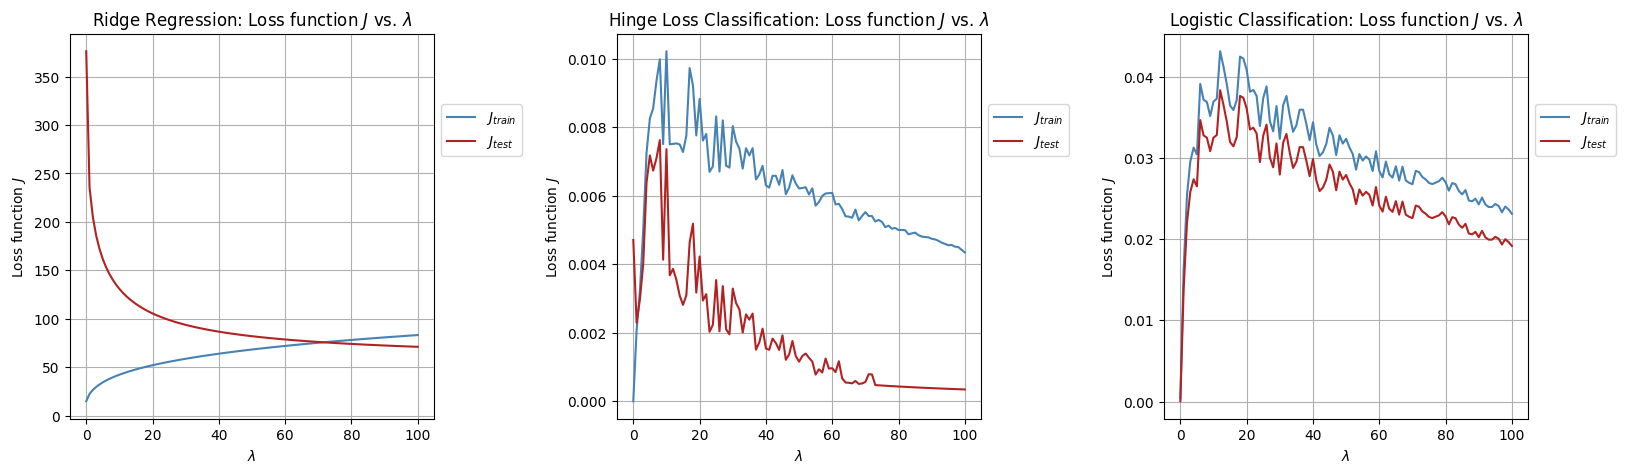

In [33]:


# Set matrix solver mode:
mode     = 'Cholesky'
method   = ['Ridge Regression', 'Hinge Loss Classification', 'Logistic Classification']

# Save fig:
save_fig  = True
fig_name  = 'machine_learning_output.png'
directory = 'img'

# Initialize lambda values:
lam_min = 0
lam_max = 1e2
N       = int(lam_max + 1)
lam_sim = np.linspace(lam_min, lam_max, N)
learning_rate = 0.01
train_steps = 500

# Initialize figs:
fig, axs = plt.subplots(1, len(method), figsize = (20, 5))

for j in range(len(method)):
    
    # Initialize arrays:
    J_train_sim = np.zeros(N)
    J_test_sim  = np.zeros(N)

    # Run simulations:
    for i in range(N):
        match method[j]:
            case 'Ridge Regression':
                J_train, J_test, _ = ML._ridge_regression(X_train, X_test, y_train, y_test, mode=mode, lam=lam_sim[i])

            case 'Hinge Loss Classification':
                model, train_loss_history, test_loss_history = ML._train_hinge_loss(
                    X_train, y_train, X_test, y_test, 
                    lam=lam_sim[i], 
                    learning_rate=learning_rate, 
                    train_steps=train_steps
                )
                # Get final loss from history lists
                J_train = train_loss_history[-1]
                J_test = test_loss_history[-1]

            case 'Logistic Classification':
                model, train_loss_history, test_loss_history = ML._train_logistic_loss(
                    X_train, y_train, X_test, y_test, 
                    lam=lam_sim[i], 
                    learning_rate=learning_rate, 
                    train_steps=train_steps
                )
                J_train = train_loss_history[-1]
                J_test = test_loss_history[-1]

        J_train_sim[i] = J_train
        J_test_sim[i] = J_test

        if (N - i) % 10 == 0:
            clear_output(wait=True)
            print(f'Iterations remaining: {N - i}')

    # Visualize results:
    axs[j].plot(lam_sim, J_train_sim, label = '$J_{train}$', color = 'steelblue')
    axs[j].plot(lam_sim, J_test_sim, label = '$J_{test}$', color = 'firebrick')

    box = axs[j].get_position()
    axs[j].set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    axs[j].legend(loc='center left', bbox_to_anchor=(1, 0.75))

    axs[j].grid()
    axs[j].set_xlabel('$\lambda$')
    axs[j].set_ylabel('Loss function $J$')
    axs[j].set_title(f'{method[j]}: Loss function $J$ vs. $\lambda$')

if save_fig:
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    fig.savefig(directory + '/' + fig_name)

plt.show()

### 2.

**(q)** Logistic Regression and Hinge-Loss Classification  
**(b)** OLS, Ridge Regression, Logistic Regression, and Hinge-Loss Classification for Binary Classification  

We can see that in the base case there is no significant difference between the classifiers. They all perform quite well, with accuracies above 90%. The reason is that all models can efficiently separate linearly separable data when the data is modeled by a Gaussian distribution with equal class sizes and variance. Furthermore, although we might expect more complex models like hinge-loss and logistic regression to perform the best, for this type of data, ridge regression actually yields the best results.



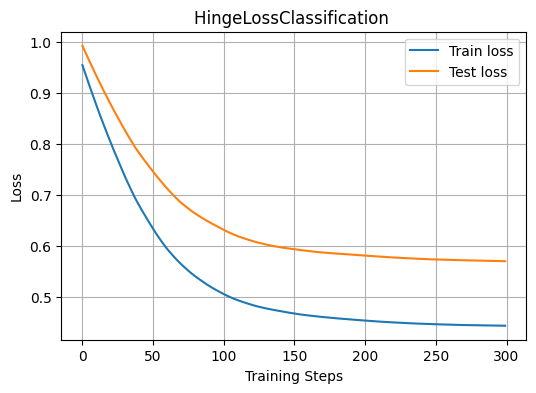

HingeLossClassification | Final Train Loss: 0.4429 | Final Test Loss: 0.5694


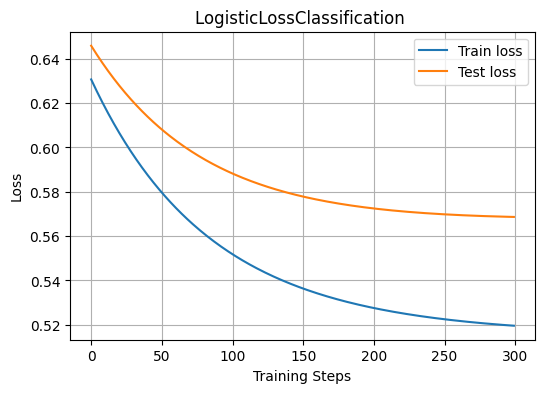

LogisticLossClassification | Final Train Loss: 0.5196 | Final Test Loss: 0.5686
Hinge-loss accuracy: 0.9166666666666666
Logistic-loss accuracy: 0.9166666666666666
OLS accuracy: 0.9166666666666666
Ridge regression accuracy: 0.9333333333333333


In [34]:
from src.Machine_Learning import HingeLossClassification, LogisticLossClassification

# return number of missclassified samples
def misclassification(X, y, w):
    y = y.reshape(-1, 1)
    preds = np.sign(X @ w)
    return int(np.sum(preds != y))


dimension = 20
samples = 300
l = 0.3
lr = 0.01

X, _, y = data._data_generation_classifier(nrows=samples, ncols=dimension)

X_train, y_train, X_test, y_test = data._data_splitting(
    X=X, y=y, mode='ratio', nrows_train=0.8
)

train_steps = 300

hingeLoss = HingeLossClassification(dimension, l, lr)
logisticLoss = LogisticLossClassification(dimension, l, lr)  
losses = [hingeLoss, logisticLoss]

loss_history = [[] for _ in losses]
test_loss_history = [[] for _ in losses]

for step in range(train_steps):
    for i, loss_function in enumerate(losses):
        # compute test loss first (will set cache)
        test_loss = loss_function.forward(X_test, y_test)
        # compute train loss (overwrites cache to train data)
        loss = loss_function.forward(X_train, y_train)

        # compute gradients
        grad = loss_function.backward()     

        # apply optimization step  
        loss_function.step()

        loss_history[i].append(loss)
        test_loss_history[i].append(test_loss)

# plotting
for i, lf in enumerate(losses):
    plt.figure(figsize=(6,4))
    plt.plot(loss_history[i], label='Train loss')
    plt.plot(test_loss_history[i], label='Test loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title(f'{type(lf).__name__} ')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"{type(lf).__name__} | Final Train Loss: {loss_history[i][-1]:.4f} | "
          f"Final Test Loss: {test_loss_history[i][-1]:.4f}")
    

accuracy = []
accuracy.append(misclassification(X_test, y_test, hingeLoss.weight[1:]))
accuracy.append(misclassification(X_test, y_test, logisticLoss.weight[1:]))



_, _, w = ML._ordinary_least_squares(X_train, X_test, y_train, y_test, mode=mode)
accuracy.append(misclassification(X_test, y_test,  w[1:].reshape(-1, 1)))

_, _, w = ML._ridge_regression(X_train, X_test, y_train, y_test, mode=mode, lam=lam_sim[k])
accuracy.append(misclassification(X_test, y_test, w[1:].reshape(-1, 1)))

print("Hinge-loss accuracy:", 1 - accuracy[0] / X_test.shape[0])
print("Logistic-loss accuracy:", 1 - accuracy[1] / X_test.shape[0])
print("OLS accuracy:", 1 - accuracy[2] / X_test.shape[0])
print("Ridge regression accuracy:", 1 - accuracy[3] / X_test.shape[0])



**(c)** To create a dataset on which OLS and ridge regression perform poorly while hinge-loss and logistic-loss perform well, we can use the following insight: OLS and ridge regression do not maximize the margin. Therefore, we can design the data so that these models place the decision boundary too close to one of the classes.

We can achieve this by:
- Making the classes different in size,
- Giving the classes different variances, and
- Introducing outliers (on the positive side, so the data remains linearly separable).

These factors cause OLS and ridge regression to shift the boundary toward the larger class, leading to more misclassifications.

We can observe that all models perform worse than in the previous question; however, hinge-loss and logistic-loss achieve accuracies that are about 15–20 percentage points higher than OLS and ridge regression.

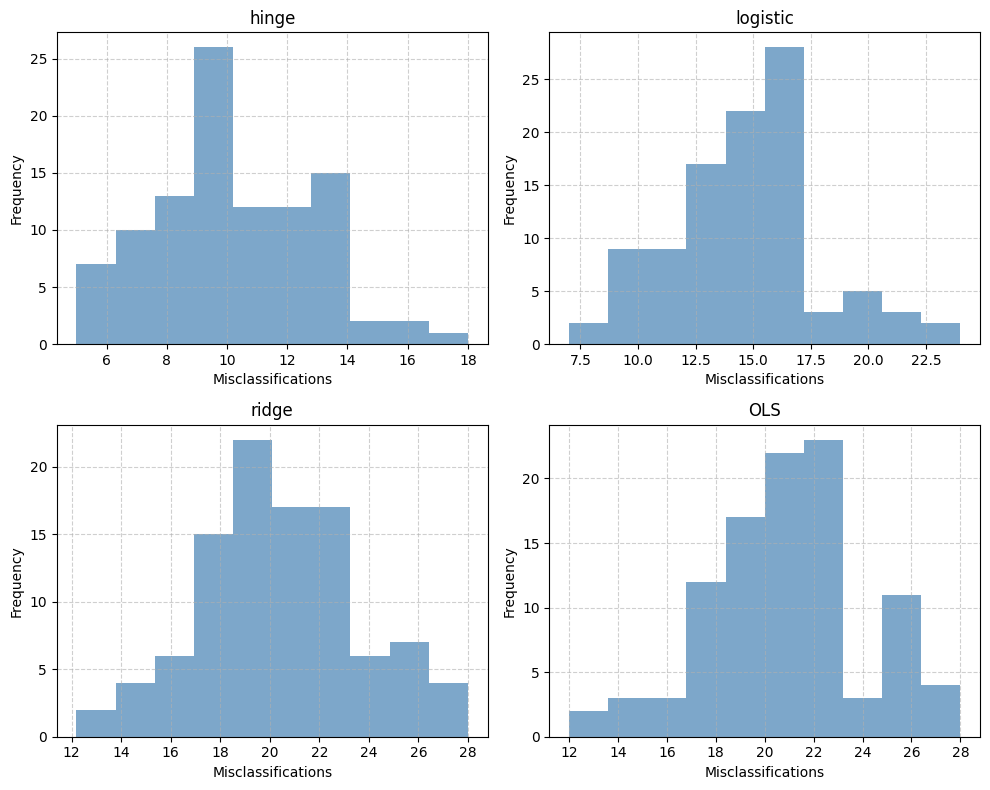

hinge average accuracy: 76.77%
logistic average accuracy: 66.64%
ridge average accuracy: 53.59%
OLS average accuracy: 52.70%


In [35]:
dimension = 20
samples = 300
l = 0.3
lr = 0.1
train_steps = 300

mode   = 'Cholesky'
methods = ['Ridge Regression', 'Ordinary Least Squares']  

lam_min, lam_max = 0.0, 1e2
N = int(lam_max + 1)                 
lam_sim = np.linspace(lam_min, lam_max, N)

random_samples = 100

# Data
# 2 clusters with different variences and sizes
# outliers(in the positive direction so still linearly separable) and small margin to make it harder for OLS
# Data generation:
# Creates a synthetic binary classification dataset designed to challenge linear models like OLS (Ordinary Least Squares)
#  while remaining linearly separable overall.

X, y, _ = data.make_ols_tricky_separable(
    n_pos=200,           # number of positive samples (class +1)
    n_neg=20,            # number of negative samples (class -1)
    ncols=dimension,     # number of input features (dimensionality of X)
    margin=0.15,         # minimum separation (margin) between positive and negative clusters
    scale_pos=1.5,       # variance scale (spread) of the positive cluster
    scale_neg=1.0,       # variance scale (spread) of the negative cluster
    outlier_frac=0.06,   # fraction of samples to turn into outliers
    outlier_multiplier=20.0,  # magnitude multiplier for outlier displacement
    seed=42              # random seed for reproducibility
)


# to store number of missclassified samples across the set number of iterations
misclassified = [[], [], [], []] 
labels = ['hinge', 'logistic', 'ridge', 'OLS']

for seed in range(random_samples):
    X_train, y_train, X_test, y_test = data._data_splitting(
        X=X, y=y, mode='ratio', nrows_train=0.8, seed=seed, random=True
    )

    # init models
    hingeLoss    = HingeLossClassification(dimension, l, lr)
    logisticLoss = LogisticLossClassification(dimension, l, lr)
    losses = [hingeLoss, logisticLoss]

    # train both losses
    for _ in range(train_steps):
        for lf in losses:
            # train loss forward
            _ = lf.forward(X_train, y_train)
            # backward (handle both return signatures)
            bw = lf.backward()
            # you can ignore returned grad; classes store it internally
            lf.step()

    # evaluate misclassification for trained classifiers
    misclassified[0].append(misclassification(X_test, y_test, hingeLoss.weight[1:]))
    misclassified[1].append(misclassification(X_test, y_test, logisticLoss.weight[1:]))

    # baselines across lambda grid
    # maybe replace with best lambda found earlier
    for m in methods:
        tot = 0
        if m == 'Ridge Regression':
            for k in range(N):
                _, _, w = ML._ridge_regression(
                    X_train, X_test, y_train, y_test, mode=mode, lam=lam_sim[k])
                tot += misclassification(X_test, y_test, w[1:].reshape(-1, 1))
            #average missclassification across lambdas
            misclassified[2].append(tot / N)

        elif m == 'Ordinary Least Squares':
            tot = 0
            for k in range(N):
                _, _, w = ML._ordinary_least_squares(
                    X_train, X_test, y_train, y_test, mode=mode)
                tot += misclassification(X_test, y_test,  w[1:].reshape(-1, 1))
            #average missclassification across lambdas
            misclassified[3].append(tot / N)


# Histograms
# Myabe change to values relative to test size
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for i, vals in enumerate(misclassified):
    axes[i].hist(vals, bins=10, color='steelblue', alpha=0.7)
    axes[i].set_title(labels[i])
    axes[i].set_xlabel('Misclassifications')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# --- Average accuracy across runs---
test_size = X_test.shape[0]  

avg_misclassified = [np.mean(vals) for vals in misclassified]
avg_accuracy = [1 - m / test_size for m in avg_misclassified]

for label, acc in zip(labels, avg_accuracy):
    print(f"{label} average accuracy: {acc:.2%}")
